<a href="https://colab.research.google.com/github/Jananisai27/Projects-JS01/blob/main/fine_tuning_distilbert_for_tamil_code_mixed_sentim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForMaskedLM, get_linear_schedule_with_warmup, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import glob
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import *
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Loading Text files

In [ ]:
Negative_tweets = pd.read_excel('/content/Negative_tweets.xlsx', header=None)
Negative_tweets.columns = ['sentence', 'sentiment']
Positive_tweets = pd.read_excel('/content/Positive_tweets.xlsx', header=None)
Positive_tweets.columns = ['sentence', 'sentiment']
Neutral_tweets = pd.read_excel('/content/neutral_tweets.xlsx', header=None)
Neutral_tweets.columns = ['sentence', 'sentiment']
Mixed_language = pd.read_excel('/content/Mixed_language.xlsx', header=None)
Mixed_language = Mixed_language.iloc[:, :3]
Mixed_language.columns = ['sentence', 'sentiment', 'manual']

In [ ]:
Negative_tweets.drop_duplicates(subset=['sentence', 'sentiment'], inplace=True)
Negative_tweets['sentiment'].value_counts()

,count
sentiment,
NEGATIVE,9245
sentiment,1


In [ ]:
Positive_tweets['sentiment'].value_counts()

,count
sentiment,
Positive,35831
sentiment,1


In [ ]:
Neutral_tweets['sentiment'].value_counts()

,count
sentiment,
NEUTRAL,5890
NEUTRAL,5056
sentiment,1


In [ ]:
Mixed_language['seq_len'] = Mixed_language['sentence'].apply(lambda x: len(str(x).split()))

# Filter rows with seq_len < 5
small_sentence_indices = Mixed_language[(Mixed_language['sentiment'] == 'POSITIVE') & ( Mixed_language['seq_len'] <= 6)].index

Mixed_language.drop(index=small_sentence_indices, inplace=True)


Mixed_language.drop('seq_len', axis=1, inplace=True)

Mixed_language.drop_duplicates(subset=['sentence', 'sentiment'], inplace=True)

print(Mixed_language.columns)

Mixed_language['sentiment'].value_counts()

Index(['sentence', 'sentiment', 'manual'], dtype='object')


,count
sentiment,
POSITIVE,16591
sentiment,1


In [ ]:
Positive_tweets['seq_len'] = Positive_tweets['sentence'].apply(lambda x: len(str(x).split()))

# Filter rows with seq_len < 5
small_sentence_indices = Positive_tweets[(Positive_tweets['sentiment'] == 'POSITIVE ') & (Positive_tweets['seq_len'] <= 6)].index

Positive_tweets.drop(index=small_sentence_indices, inplace=True)

Positive_tweets.drop('seq_len',axis=1, inplace=True)

Positive_tweets.drop_duplicates(subset=['sentence'], inplace=True)

Positive_tweets['sentiment'].value_counts()



,count
sentiment,
Positive,34615
sentiment,1


In [ ]:
all_df = pd.concat(([Positive_tweets,Negative_tweets,Neutral_tweets]), ignore_index=True)

nan = all_df[all_df['sentence'].isnull()].index     # handling sentences with null values

all_df.drop(index=nan, inplace=True)

print(all_df.count())

sentence     54806
sentiment    54806
dtype: int64


In [ ]:
all_df.loc[all_df['sentiment'] == 'POSITIVE ', 'sentiment'] = 'POSITIVE'
all_df.loc[all_df['sentiment'] == 'NEGATIVE ', 'sentiment'] = 'NEGATIVE'
all_df.loc[all_df['sentiment'] == 'NEUTRAL ', 'sentiment'] = 'NEUTRAL'


In [ ]:
all_df.drop_duplicates(inplace=True)
all_df = all_df[all_df['sentiment'] != 'sentiment']
all_df['sentiment'].value_counts()

,count
sentiment,
Positive,34614
NEUTRAL,9907
NEGATIVE,9244


In [ ]:
X = all_df['sentence']

le = LabelEncoder()
y = le.fit_transform(all_df['sentiment'])

print(y)
print("Category Mapping:", le.classes_)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_df = pd.DataFrame({'sentence':X_train,'sentiment':y_train})
test_df = pd.DataFrame({'sentence':X_test,'sentiment':y_test})

[2 2 2 ... 1 1 1]
Category Mapping: ['NEGATIVE' 'NEUTRAL' 'Positive']


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

In [ ]:
def tokenize(ds):
  # Ensure all items in the 'sentence' list are strings
  sentences_as_strings = [str(s) for s in ds['sentence']]
  return tokenizer(
      sentences_as_strings,
      max_length=64,
      padding='max_length',
      truncation=True,
      return_tensors='pt'
  )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)


Map:   0%|          | 0/43012 [00:00<?, ? examples/s]

Map:   0%|          | 0/10753 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['sentence', 'sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 43012
})

In [ ]:
muril = AutoModelForMaskedLM.from_pretrained("google/muril-base-cased")

for param in muril.parameters():
  param.requires_grad = False

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class MurilCustomClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MurilCustomClassifier, self).__init__()
        self.muril = muril
        self.dropout = nn.Dropout(0.1)
        self.preclassifier = nn.Linear(self.muril.config.vocab_size,self.muril.config.hidden_size)
        self.classifier = nn.Linear(self.muril.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        muril_output = self.muril(input_ids=input_ids, attention_mask=attention_mask) #(bs,seq_len,dim)
        hidden_state = muril_output[0]                                                #(bs,dim)
        pooled_output = hidden_state[:,0]
        pooled_output = self.preclassifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MurilCustomClassifier(num_classes=3).to(device)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()



In [ ]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    preds, true_labels = [], []
    for batch in tqdm(loader, desc="Training"):
        optimizer.zero_grad()


        input_ids = torch.from_numpy(np.asarray(batch['input_ids']))
        input_ids = torch.transpose(input_ids,0,1).to(device)
        attention_mask = torch.from_numpy(np.asarray(batch['attention_mask']))
        attention_mask = torch.transpose(attention_mask,0,1).to(device)
        labels = torch.from_numpy(np.asarray(batch['sentiment'])).to(device)



        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    acc = accuracy_score(true_labels, preds)
    training_loss = total_loss / len(loader)
    return training_loss, acc

In [ ]:
def eval_model(model, loader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():

        for batch in tqdm(loader, desc="Evaluating"):
           input_ids = torch.from_numpy(np.asarray(batch['input_ids']))
           input_ids = torch.transpose(input_ids,0,1).to(device)
           attention_mask = torch.from_numpy(np.asarray(batch['attention_mask']))
           attention_mask = torch.transpose(attention_mask,0,1).to(device)
           labels = torch.from_numpy(np.asarray(batch['sentiment'])).to(device)

           outputs = model(input_ids, attention_mask)
           predictions = torch.argmax(outputs, dim=1)


           preds.extend(predictions.cpu().numpy())
           true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average="weighted")
    return acc, f1, true_labels, preds


In [ ]:
trainable_layers = ['preclassifier', 'classifier']

for name, param in model.named_parameters():
  param.requires_grad = any(layer in name for layer in trainable_layers)
  if param.requires_grad == True:
     print(name)

preclassifier.weight
preclassifier.bias
classifier.weight
classifier.bias


In [ ]:
for epoch in range(2):
    train_loss, train_accuracy = train_epoch(model, train_loader)
    acc, f1, preds, labels = eval_model(model, test_loader)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} | Train Accuracy={train_accuracy:.4f} |")
    # print(preds)
    # print(labels)
    print(f"Val Acc={acc:.4f} | Val F1={f1:.4f}")

Training:   0%|          | 0/1345 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), 'distilbert_classifier.pt')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DistilBertCustomClassifier(num_classes=2).to(device)

In [ ]:
test_df = pd.read_excel('Mixed_language.xlsx', header=None)
test_df = test_df.iloc[:, :3]
test_df.columns = ['sentence', 'sentiment', 'manual']


test_df['sentiment'] = test_df['sentiment'].astype(str).str.strip()


test_df.loc[test_df['sentiment'] == 'POSITIVE', 'sentiment'] = 'Positive'


test_df = test_df[test_df['sentiment'] != 'sentiment']

test_df = test_df.reset_index(drop=True)

# Apply the same LabelEncoder to the 'sentiment' column of the new test_df
test_df['sentiment'] = le.transform(test_df['sentiment'])

test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.map(tokenize, batched=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Map:   0%|          | 0/21524 [00:00<?, ? examples/s]

In [ ]:
acc, f1, true_labels, preds = eval_model(model, test_loader)
print(f"Accuracy = {acc:.4f} | F1 = {f1:.4f}")
print(true_labels)
print(preds)

Evaluating:   0%|          | 0/673 [00:00<?, ?it/s]

Accuracy = 0.9101 | F1 = 0.9530
[np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.in

In [ ]:
correct_df = pd.DataFrame({'sentence':[],
                           'y_true':[],
                           'y_pred':[]})

error_df = pd.DataFrame({'sentence':[],
                           'y_true':[],
                           'y_pred':[]})

for index, prediction in enumerate(preds) :
  review = test_df['sentence'][index]
  if prediction == true_labels[index]:
    correct_df.loc[len(correct_df)] = [review, true_labels[index], prediction]

  else:
    error_df.loc[len(error_df)] = [review, true_labels[index], prediction]


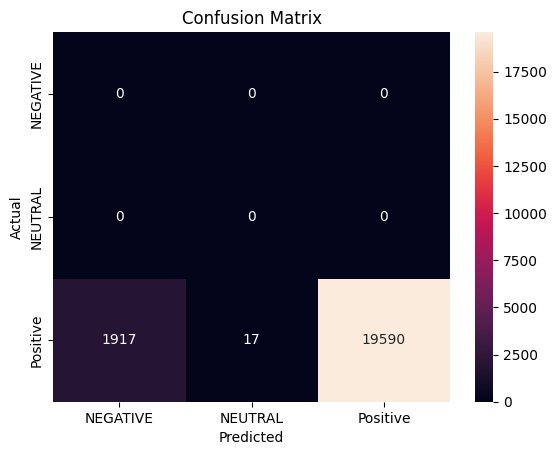

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, preds)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
correct = len(correct_df)
wrong = len(error_df)

plt.figure(figsize=(6,4))
plt.bar(['Correct Predictions', 'Wrong Predictions'], [correct, wrong])
plt.title('Model Prediction Performance')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
correct_df.to_excel('correct_predictions.xlsx')
error_df.to_excel('error_predictions.xlsx')